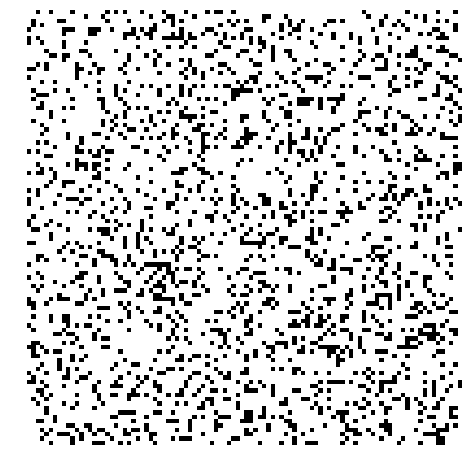

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

minutia_prob = 0.2
g = np.floor(np.random.random((100, 100)) + minutia_prob)
plt.figure(figsize=(8, 8))
plt.imshow(g, cmap='Greys', interpolation='nearest')
plt.axis('off');

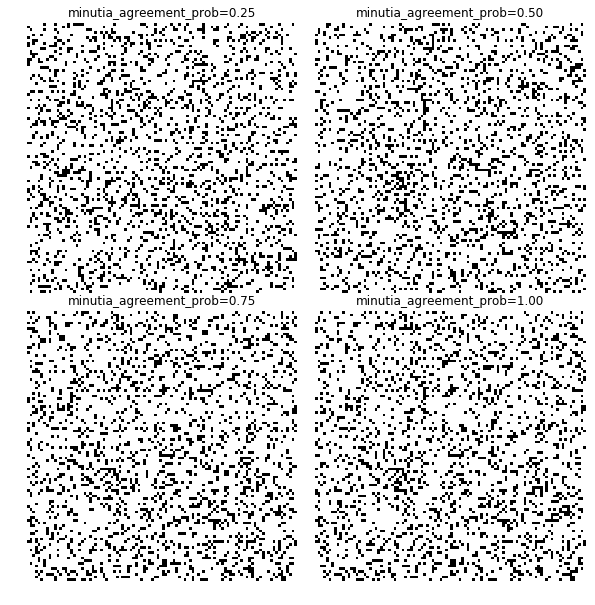

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid

# return a similar grid where bits are flipped with a certain prob
def get_dupe(g, minutia_agreement_prob=0.8):
    h = g.flatten()
    pos = np.argwhere(h == True).flatten()
    n_pos = len(pos)
    js = int((n_pos - (n_pos * minutia_agreement_prob)) /
             (1 + minutia_agreement_prob))
    n_pos_to_flip = n_pos - js
    p = n_pos_to_flip / n_pos
    pos_flip = np.random.random(n_pos) > p
    neg = np.argwhere(h == False).flatten()
    h[pos] = np.logical_xor(h[pos], pos_flip)
    h[np.random.choice(neg, sum(pos_flip), replace=False)] = True
    return h.reshape(g.shape)

fig = plt.figure(1, (10, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.25, share_all=True)

for i, prob in zip(range(4), [0.25, 0.50, 0.75, 1]):    
    grid[i].imshow(get_dupe(g, prob), cmap='Greys', interpolation='nearest')
    grid[i].set_axis_off()
    grid[i].set_title('minutia_agreement_prob=%.2f' % prob)

In [3]:
def get_similarity(g1, g2):
    s1 = set(np.argwhere(g1.flatten() == True).flatten())
    s2 = set(np.argwhere(g2.flatten() == True).flatten())
    return len(s1 & s2) / len(s1 | s2) 

def get_hamming_similarity(g1, g2):
    return np.sum(~np.logical_xor(g1, g2)) / g1.size

for prob in [0.25, 0.50, 0.75, 1]:
    d = get_dupe(g, prob)
    print('prob=%.2f, sim=%.4f, sim=%.4f' % (prob, get_similarity(g, d), get_hamming_similarity(g, d)))

prob=0.25, sim=0.2432, sim=0.7582
prob=0.50, sim=0.4871, sim=0.8630
prob=0.75, sim=0.7513, sim=0.9436
prob=1.00, sim=1.0000, sim=1.0000


In [4]:
def get_fingerprints(grid_size=50, minutia_prob=0.2, 
                     n_total=5000, n_unique=1000):
    # uniques
    fps = {
        i: (i, np.floor(np.random.random(grid_size ** 2) + minutia_prob).astype(bool))
            for i in range(n_unique)
    }
    # dupes
    for i in range(n_unique, n_total):
        u = np.random.randint(0, n_unique)
        fps[i] = (u, get_dupe(fps[u][1]))
    return fps

fps = get_fingerprints(n_total=5000, n_unique=1000)

In [5]:
def get_grid_hashers(n_buckets=1024, n_squares=3, grid_size=50):
    return [
        np.random.choice(range(grid_size ** 2), size=n_squares, replace=False)
        for _ in range(n_buckets)
    ]

hashers = get_grid_hashers()

In [6]:
from collections import defaultdict

def get_candidate_pairs(fps, hashers):
    # buckets of candidate pairs
    buckets = defaultdict(list)
    for i, fp in fps.items():
        for hasher in hashers:
            if np.all(fp[1][hasher]):
                buckets[tuple(hasher)].append(i)
    return buckets

%time buckets = get_candidate_pairs(fps, hashers)

CPU times: user 29.2 s, sys: 8 ms, total: 29.2 s
Wall time: 29.2 s


In [7]:
len(buckets), np.average([len(b) for b in buckets.values()])

(1024, 39.8798828125)

In [8]:
# https://www.ics.uci.edu/~eppstein/PADS/UnionFind.py
class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)
    
    def sets(self):
        ss = defaultdict(set)
        for k, v in self.parents.items():
            ss[v].add(k)
        return ss.values()

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest

                
def get_similar_groups(fps, buckets, min_sim_threshold):
    groups = UnionFind()
    for i in range(len(fps)):
        groups.union(i)
    cache = set()
    n_comps = 0
    for bucket in buckets.values():
        for idx, i in enumerate(bucket):
            for j in bucket[idx+1:]:
                sij = frozenset([i, j])
                if sij in cache:
                    continue
                cache.add(sij)
                n_comps += 1
                if get_similarity(fps[i][1], fps[j][1]) >= min_sim_threshold:
                    groups.union(i, j)
    print(n_comps)
    return groups

%time groups = get_similar_groups(fps, buckets, 0.75)

# with cache:
# 784459
# CPU times: user 31.3 s, sys: 386 ms, total: 31.7 s
# Wall time: 32.1 s
    
# without cache:
# 835481
# CPU times: user 29.5 s, sys: 83.2 ms, total: 29.6 s
# Wall time: 29.9 s

796950
CPU times: user 3min 39s, sys: 980 ms, total: 3min 40s
Wall time: 3min 40s


In [9]:
len(groups.sets()), np.average([len(g) for g in groups.sets()])

(1048, 4.770992366412214)

In [10]:
truth = defaultdict(set)
for i, fp in fps.items():
    truth[fp[0]].add(i)

In [11]:
retrieved = defaultdict(set)
for s in groups.sets():
    us = {fps[i][0] for i in s}
    assert len(us) == 1
    retrieved[list(us)[0]] = set(s)

In [12]:
nfp = 0
nfn = 0
for i, s in truth.items():
    nfp += len(retrieved[i] - truth[i])
    nfn += len(truth[i] - retrieved[i])
nfp, nfn

(0, 207)